In [37]:
"""
Asset selling driver script
"""
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import pandas as pd
import numpy as np
from AssetSellingModel import AssetSellingModel
from AssetSellingPolicy import AssetSellingPolicy

import matplotlib.pyplot as plt
from copy import copy
import time

plt.rcParams["figure.figsize"] = (15, 8)


# read in policy parameters from an Excel spreadsheet, "asset_selling_policy_parameters.xlsx"
sheet1 = pd.read_excel("asset_selling_policy_parameters.xlsx", sheet_name="Sheet1")
params = zip(sheet1["param1"], sheet1["param2"])
param_list = list(params)
sheet2 = pd.read_excel("asset_selling_policy_parameters.xlsx", sheet_name="Sheet2")
sheet3 = pd.read_excel("asset_selling_policy_parameters.xlsx", sheet_name="Sheet3")
biasdf = pd.read_excel(
    "asset_selling_policy_parameters.xlsx", sheet_name="Sheet4", index_col=0
)

policy_selected = sheet3["Policy"][0]
T = sheet3["TimeHorizon"][0]
gamma = sheet3["DiscountFactor"][0]
initPrice = sheet3["InitialPrice"][0]
initBias = sheet3["InitialBias"][0]

exog_params = {
    "UpStep": sheet3["UpStep"][0],
    "DownStep": sheet3["DownStep"][0],
    "Variance": sheet3["Variance"][0],
    "biasdf": biasdf,
}

nIterations = sheet3["Iterations"][0]
printStep = sheet3["PrintStep"][0]
printIterations = [0]
printIterations.extend(list(reversed(range(nIterations - 1, 0, -printStep))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Selected policy high_low, time horizon 40, initial price 16 and number of iterations 10
obj=19.79111457165243, state.resource=0
obj=19.472477953279128, state.resource=0
obj=3.0774365151067538, state.resource=0
obj=19.640142673616324, state.resource=0
obj=21.015132064442955, state.resource=0
obj=19.591990022194015, state.resource=0
obj=21.514787937361888, state.resource=0
obj=21.940577605979783, state.resource=0
obj=19.03769500808756, state.resource=0
obj=20.939863159260764, state.resource=0
Contribution per iteration: 
   objective  stopping time
0  19.791115              6
1  19.472478             11
2   3.077437             14
3  19.640143              5
4  21.015132              3
5  19.591990              6
6  21.514788             10
7  21.940578              3
8  19.037695              6
9  20.939863              2
Cumulative average contribution per iteration: 
0    19.791115
1    19.631796
2    14.113676
3    15.495293
4    16.599261
5    17.098049
6    17.729012
7    18.255457

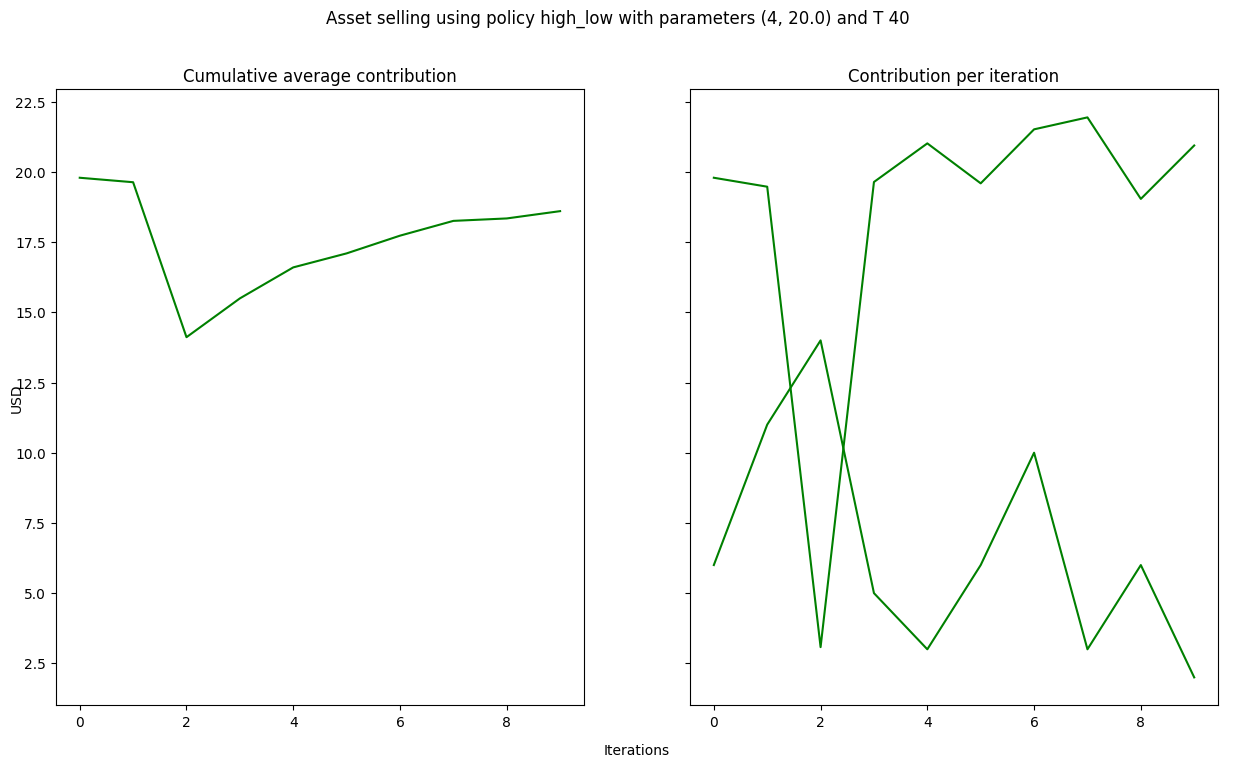

0.9196979999542236 secs


In [40]:
# initialize the model and the policy
policy_names = ["sell_low", "high_low", "track"]
state_names = ["price", "price_smoothed", "resource", "bias"]
init_state = {
    "price": initPrice,
    "price_smoothed": initPrice,
    "resource": 1,
    "bias": initBias,
}
decision_names = ["sell", "hold"]

M = AssetSellingModel(state_names, decision_names, init_state, exog_params, T, gamma)
P = AssetSellingPolicy(M, policy_names)
t = 0

# make a policy_info dict object
policy_info = {
    "sell_low": param_list[0],
    "high_low": param_list[1],
    "track": param_list[2],
}

start = time.time()
print(
    "Selected policy {}, time horizon {}, initial price {} and number of iterations {}".format(
        policy_selected, T, initPrice, nIterations
    )
)

if policy_selected in ["sell_low", "high_low"]:
    contribution_iterations = [
        P.run_policy(policy_info, policy_selected, t)
        for ite in range(nIterations)
    ]
    contribution_iterations = pd.DataFrame(contribution_iterations, columns=["objective", "stopping time"])

    print("Contribution per iteration: ")
    print(contribution_iterations)
    cum_avg_contrib = contribution_iterations["objective"].expanding().mean()

    print("Cumulative average contribution per iteration: ")
    print(cum_avg_contrib)

    # plotting the results
    fig, axsubs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(
        "Asset selling using policy {} with parameters {} and T {}".format(
            policy_selected, policy_info[policy_selected], T
        )
    )
    i = np.arange(0, nIterations, 1)

    axsubs[0].plot(i, cum_avg_contrib, "g")
    axsubs[0].set_title("Cumulative average contribution")

    axsubs[1].plot(i, contribution_iterations, "g")
    axsubs[1].set_title("Contribution per iteration")

    # Create a big subplot
    ax = fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)

    ax.set_ylabel("USD", labelpad=0)  # Use argument `labelpad` to move label downwards.
    ax.set_xlabel("Iterations", labelpad=10)

    plt.show()

elif policy_selected == "track":
    theta = policy_info["track"][0]
    policy_info["track"] = (
        theta,
        None,
    )
    res = []
    t_stop_arr = []
    for k in range(nIterations):
        contrib, t_stop = P.run_policy(policy_info, policy_selected, t)
        res.append(contrib)
        t_stop_arr.append(t_stop)
        print(
            "Iteration {} for theta {}. The contribution was {} and the stopping time was {}".format(
                k, theta, contrib, t_stop
            )
        )
    avg_contrib = np.array(res).mean()
    avg_t_stop = np.array(t_stop_arr).mean()
    print("\n")
    print(
        "**************************************************************************************"
    )
    print(
        "Finishing iterations for theta {}. Average contribution {} and average stopping time {}".format(
            theta, avg_contrib, avg_t_stop
        )
    )

else:
    # obtain the theta values to carry out a full grid search
    grid_search_theta_values = P.grid_search_theta_values(
        sheet2["low_min"],
        sheet2["low_max"],
        sheet2["high_min"],
        sheet2["high_max"],
        sheet2["increment_size"],
    )
    # use those theta values to calculate corresponding contribution values

    contribution_iterations = [
        P.vary_theta(policy_info, "high_low", t, grid_search_theta_values[0])
        for ite in list(range(nIterations))
    ]

    contribution_iterations_arr = np.array(contribution_iterations)
    cum_sum_contrib = contribution_iterations_arr.cumsum(axis=0)
    nElem = np.arange(1, cum_sum_contrib.shape[0] + 1).reshape(
        (cum_sum_contrib.shape[0], 1)
    )
    cum_avg_contrib = cum_sum_contrib / nElem
    print("cum_avg_contrib")
    print(cum_avg_contrib)

    # plot those contribution values on a heat map
    P.plot_heat_map_many(
        cum_avg_contrib,
        grid_search_theta_values[1],
        grid_search_theta_values[2],
        printIterations,
    )

end = time.time()
print("{} secs".format(end - start))